VDP example with Zhang DMD

In [1]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.integrate import solve_ivp
import matplotlib.animation as animation

from odmd import OnlineDMD
from odmd import WindowDMD
import time

In [2]:
%run fDMD_functions.ipynb


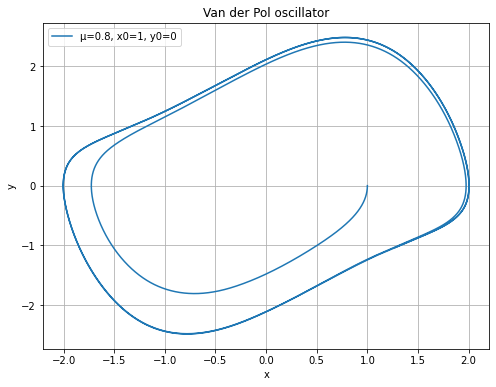

(2, 2001)


In [3]:
#Van der Pol oscillator system
initial_condition = (1,0)
mu = 0.8
t_span=(0,20)
t_eval = np.linspace(t_span[0], t_span[1], 2000001)


def van_der_pol(t, state, mu):
    x, y = state
    dxdt = y
    dydt = mu * (1 - x**2) * y - x
    return [dxdt, dydt]


sol = solve_ivp(van_der_pol, t_span, [initial_condition[0], initial_condition[1]], args=(mu,), t_eval=t_eval, vectorized=True) #u sol.y[0] i sol.y[1] su (x,y) koordinate točke za svaki trenutak

#print(sol.y[0].shape, sol.y[1].shape)
#print(sol.t.shape)

plt.figure(figsize=(8,6))
plt.plot(sol.y[0], sol.y[1], label=f"μ={mu}, x0={initial_condition[0]}, y0={initial_condition[1]}")

    
plt.title("Van der Pol oscillator")
plt.xlabel("x")
plt.ylabel("y")
plt.legend()
plt.grid()
plt.show()

t_used=np.arange(0,2000001,1000)
del (t_eval)
vdp = sol.y[:,t_used]
#vremenski intervali 0.01, od trena 0 do 20
print(vdp.shape)



In [4]:
(n,m)=vdp.shape

In [5]:
#bez stackanja

q = 10 #toliko uzmem za pocetak
#evalsonlineDMD1 = np.empty((n, m), dtype=complex)
odmd = OnlineDMD(n, 1.0)
odmd.initialize(vdp[:, :q], vdp[:, 1:q+1])
start = time.time()
for k in range(q, m-1):
    odmd.update(vdp[:, k], vdp[:, k+1])
    #evalsonlineDMD1[:, k] = np.log(np.linalg.eigvals(odmd.A))/dt
end = time.time()
print("Online DMD, weighting = 1, time = " + str(end-start) + " secs")

Lambda, Z = odmd.computemodes()
print(Lambda)
print(Z)

Online DMD, weighting = 1, time = 0.049844980239868164 secs
[1.00004999+0.010036j 1.00004999-0.010036j]
[[0.00705154-0.70580708j 0.00705154+0.70580708j]
 [0.708369  +0.j         0.708369  -0.j        ]]


In [6]:
Z_nas, Lambda_nas, r, Q, L = fGEDMDQ_multiple_trajectories(vdp[:,:q], vdp[:,1:q+1])
start_nas = time.time()
for k in range(q, m-1):
    Z_nas, Lambda_nas, r, Q, L = fDMD_added_snap(np.bmat([vdp[:,k],vdp[:,k+1]]).T, Q, L)
end_nas = time.time()
print("time: ", end_nas-start_nas, "sec")

print(Lambda_nas); print(Z)

#isti rezultati, ali nase puno sporije..

time:  0.5834863185882568 sec
[1.00004999+0.010036j 1.00004999-0.010036j]
[[0.00705154-0.70580708j 0.00705154+0.70580708j]
 [0.708369  +0.j         0.708369  -0.j        ]]


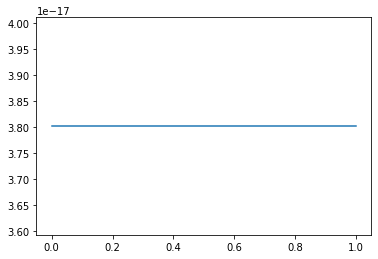

In [7]:
plt.plot(r) #provjeri je li se krivo racuna.. :::: DOBRO JE SADA

c:\Users\elawi\miniconda3\envs\myenv\lib\site-packages\ipykernel_launcher.py:9: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if __name__ == '__main__':


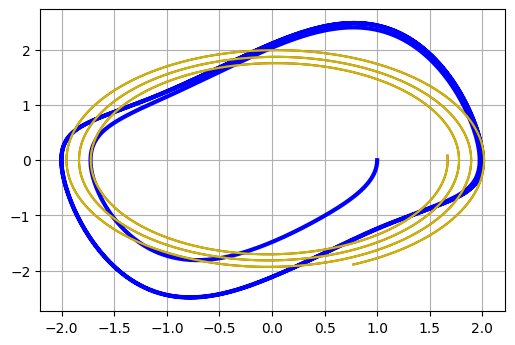

In [8]:
#kako izgleda rekonstrukcija s ovim modovima?
indices=np.array([0,1]); times=[i for i in range(m)]

reconstructed = DMD_reconstruction(vdp, Z_nas, indices, Lambda_nas, times)
reconstructed_zhang = DMD_reconstruction(vdp, Z, indices, Lambda, times)

plt.figure(dpi=100)
plt.plot(vdp[0,:], vdp[1,:], color="blue", lw=3)
plt.plot(reconstructed[0,:], reconstructed[1,:], color="red")
plt.plot(reconstructed_zhang[0,:], reconstructed_zhang[1,:], color="y")
plt.grid()

#jasno da je lose.. moramo stackat - isto za nas i za njihov

## WINDOW

kada jedan unaprijed gledam

In [15]:
w = 15 #toliko uzmem za pocetak
n = vdp.shape[0]; m = vdp.shape[1]

times_init=[i for i in range(w+1)]; times=[w]

wdmd = WindowDMD(n, w)
wdmd.initialize(vdp[:,:w], vdp[:,1:w+1]) # this is necessary for window DMD
start = time.time()
for k in range(w, m-1):
    wdmd.update(vdp[:, k], vdp[:, k+1])
    Lambda_w, Z_w = wdmd.computemodes()
    if k==w:
        reconstructed_njihovo_w = DMD_reconstruction(vdp[:,:w], Z_w, 'all', Lambda_w, times_init)
    else:
        reconstructed_njihovo_w = np.append(reconstructed_njihovo_w,DMD_reconstruction(vdp[:,k-w+1:k+1], Z_w, 'all', Lambda_w, times), axis=1)
end = time.time()
Lambda_w, Z_w = wdmd.computemodes()

print(Lambda_w,)

print("Window DMD, weighting = 1, time = " + str(end-start) + " secs")

Z_nas_w, Lambda_nas_w, r, Q, L = fGEDMDQ_multiple_trajectories(vdp[:,:q], vdp[:,1:q+1])
start_nas = time.time()
for k in range(w, m-1):
    _,_,_, Q, L = fDMD_discarding_snap(Q, L, 1)
    Z_nas_w, Lambda_nas_w, r, Q, L = fDMD_added_snap(np.bmat([vdp[:,k],vdp[:,k+1]]).T, Q, L)
    if k==w:
        reconstructed_nas_w = DMD_reconstruction(vdp[:,:w], Z_nas_w, 'all', Lambda_nas_w, times_init)
    else:
        reconstructed_nas_w = np.append(reconstructed_nas_w,DMD_reconstruction(vdp[:,k-w+1:k+1], Z_nas_w, 'all', Lambda_nas_w, times), axis=1)
end_nas = time.time()
print("time: ", end_nas-start_nas, "sec")

print(Lambda_nas_w); print(Z_w)

print(Lambda_nas_w-Lambda_w), print(Z_nas_w-Z_w)

print(Lambda_w); print(Z_w)


[0.99920638 1.00899491]
Window DMD, weighting = 1, time = 0.8301658630371094 secs
time:  1.516136884689331 sec
[0.99910505 1.00924441]
[[-0.99686359 -0.74496448]
 [ 0.07913899 -0.66710413]]
[-0.00010133  0.00024949]
[[ 0.0008475   0.00910926]
 [ 0.01003472 -0.01003478]]
[0.99920638 1.00899491]
[[-0.99686359 -0.74496448]
 [ 0.07913899 -0.66710413]]


Text(0.5, 1.0, 'All indices - our reconstruction')

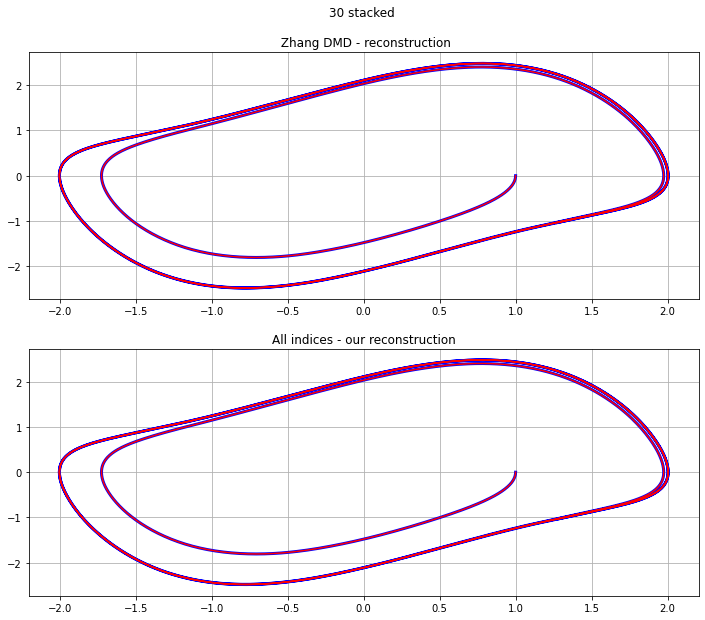

In [ ]:
kraj=m
plt.figure(figsize=(12, 10))

plt.subplot(2,1,1)
plt.plot(vdp[-2,:kraj], vdp[-1,:kraj], color="blue", lw=3)
plt.plot(reconstructed_njihovo_w[-2,:kraj], reconstructed_njihovo_w[-1,:kraj], color="red")
plt.grid()
plt.title("Zhang")

plt.subplot(2,1,2)
plt.plot(vdp[-2,:kraj], vdp[-1,:kraj], color="blue", lw=3)
plt.plot(reconstructed_nas_w[-2,:kraj], reconstructed_nas_w[-1,:kraj], color="red")
plt.grid()
plt.title("Ours")

#savrsena rekonstrukcija u oba


kada vise unaprijed gledam

[0.99920638 1.00899491]
Window DMD, weighting = 1, time = 0.8188402652740479 secs
time:  1.5975146293640137 sec
[0.99910505 1.00924441]
[[-0.99686359 -0.74496448]
 [ 0.07913899 -0.66710413]]
[0.99920638 1.00899491]
[[-0.99686359 -0.74496448]
 [ 0.07913899 -0.66710413]]
[-0.00010133  0.00024949]
[[ 0.0008475   0.00910926]
 [ 0.01003472 -0.01003478]]


Text(0.5, 1.0, 'Ours')

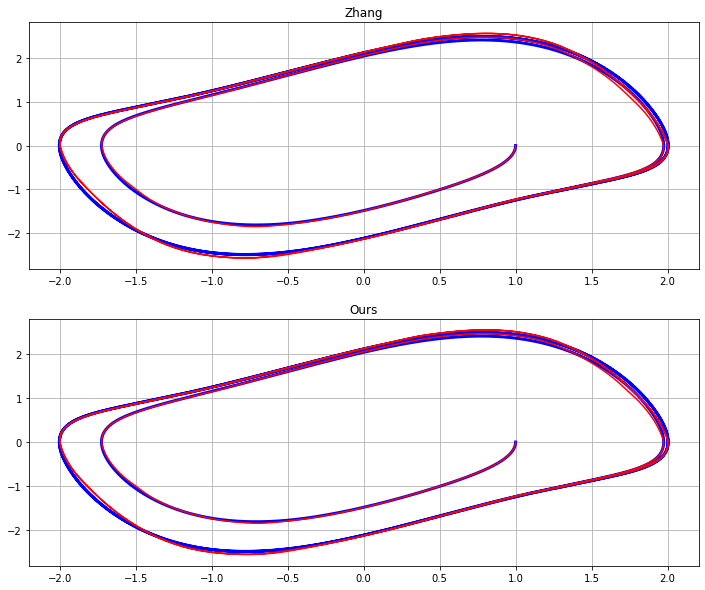

In [24]:
w = 15 #toliko uzmem za pocetak
n = vdp.shape[0]; m = vdp.shape[1]

unaprijed=20

times_init=[i for i in range(w+unaprijed)]; times=[w+unaprijed]

wdmd = WindowDMD(n, w)
wdmd.initialize(vdp[:,:w], vdp[:,1:w+1]) # this is necessary for window DMD
start = time.time()
for k in range(w, m-1):
    wdmd.update(vdp[:, k], vdp[:, k+1])
    Lambda_w, Z_w = wdmd.computemodes()
    if k==w:
        reconstructed_njihovo_w = DMD_reconstruction(vdp[:,:w], Z_w, 'all', Lambda_w, times_init)
    else:
        reconstructed_njihovo_w = np.append(reconstructed_njihovo_w,DMD_reconstruction(vdp[:,k-w+1:k+1], Z_w, 'all', Lambda_w, times), axis=1)
end = time.time()
Lambda_w, Z_w = wdmd.computemodes()

print(Lambda_w,)

print("Window DMD, weighting = 1, time = " + str(end-start) + " secs")

Z_nas_w, Lambda_nas_w, r, Q, L = fGEDMDQ_multiple_trajectories(vdp[:,:q], vdp[:,1:q+1])
start_nas = time.time()
for k in range(w, m-1):
    _,_,_, Q, L = fDMD_discarding_snap(Q, L, 1)
    Z_nas_w, Lambda_nas_w, r, Q, L = fDMD_added_snap(np.bmat([vdp[:,k],vdp[:,k+1]]).T, Q, L)
    if k==w:
        reconstructed_nas_w = DMD_reconstruction(vdp[:,:w], Z_nas_w, 'all', Lambda_nas_w, times_init)
    else:
        reconstructed_nas_w = np.append(reconstructed_nas_w,DMD_reconstruction(vdp[:,k-w+1:k+1], Z_nas_w, 'all', Lambda_nas_w, times), axis=1)
end_nas = time.time()
print("time: ", end_nas-start_nas, "sec")

print(Lambda_nas_w); print(Z_w)

print(Lambda_w); print(Z_w)

print(Lambda_nas_w-Lambda_w), print(Z_nas_w-Z_w)

kraj=m
plt.figure(figsize=(12, 10))

plt.subplot(2,1,1)
plt.plot(vdp[-2,:kraj], vdp[-1,:kraj], color="blue", lw=3)
plt.plot(reconstructed_njihovo_w[-2,:kraj], reconstructed_njihovo_w[-1,:kraj], color="red")
plt.grid()
plt.title("Zhang")

plt.subplot(2,1,2)
plt.plot(vdp[-2,:kraj], vdp[-1,:kraj], color="blue", lw=3)
plt.plot(reconstructed_nas_w[-2,:kraj], reconstructed_nas_w[-1,:kraj], color="red")
plt.grid()
plt.title("Ours")

#za 5 opet super u oba slucaja, i za 10, za 20 malo curi ali i dalje dobro



# STACKED

In [11]:
#pazi da ne runas vise od jednom..

#num_stack = 30
num_stack=60
#num_stack=70 
m=vdp.shape[1]
vdp_end=vdp[:,-num_stack:]
vdp = vdp[:,:(m-num_stack+1)]

for i in range(1,num_stack):
    added=np.concatenate((vdp[:2,i:], vdp_end[:2,:i]), axis=1)
    vdp=np.vstack((vdp,added))

(n, m)=vdp.shape

In [12]:
q = 300 #toliko uzmem za pocetak
kraj=m
odmd1 = OnlineDMD(n, 1.0)
odmd1.initialize(vdp[:, :q], vdp[:, 1:q+1]) #vec ako ovo rekonstruiram i plotam problemi.. zasto?
start = time.time()
for k in range(q, kraj-1):
    odmd1.update(vdp[:, k], vdp[:, k+1])
    #evalsonlineDMD1[:, k] = np.log(np.linalg.eigvals(odmd.A))/dt
end = time.time()
print("Online DMD, weighting = 1, time = " + str(end-start) + " secs")

Lambda, Z = odmd1.computemodes()
print(Lambda)
print(Z)

Online DMD, weighting = 1, time = 0.3431522846221924 secs
[-0.97009466+0.10032365j -0.97009466-0.10032365j -0.96825293+0.010445j
 -0.96825293-0.010445j   -0.95384767+0.20695755j -0.95384767-0.20695755j
 -0.95024733+0.14058668j -0.95024733-0.14058668j -0.9239721 +0.30930447j
 -0.9239721 -0.30930447j -0.91723188+0.27329008j -0.91723188-0.27329008j
 -0.88485867+0.39558316j -0.88485867-0.39558316j -0.84007795+0.49308686j
 -0.84007795-0.49308686j -0.8698566 +0.41522711j -0.8698566 -0.41522711j
 -0.78263995+0.58270828j -0.78263995-0.58270828j -0.79837654+0.53350128j
 -0.79837654-0.53350128j -0.70677261+0.66799375j -0.70677261-0.66799375j
 -0.72019457+0.64585698j -0.72019457-0.64585698j -0.6422153 +0.73071565j
 -0.6422153 -0.73071565j -0.60599632+0.75232987j -0.60599632-0.75232987j
 -0.56074104+0.7963475j  -0.56074104-0.7963475j  -0.46944764+0.85393137j
 -0.46944764-0.85393137j -0.4954532 +0.82645609j -0.4954532 -0.82645609j
 -0.59467207+0.48946368j -0.59467207-0.48946368j -0.37415974+0.88985

In [13]:
Z.shape

(120, 120)

c:\Users\elawi\miniconda3\envs\myenv\lib\site-packages\ipykernel_launcher.py:9: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if __name__ == '__main__':


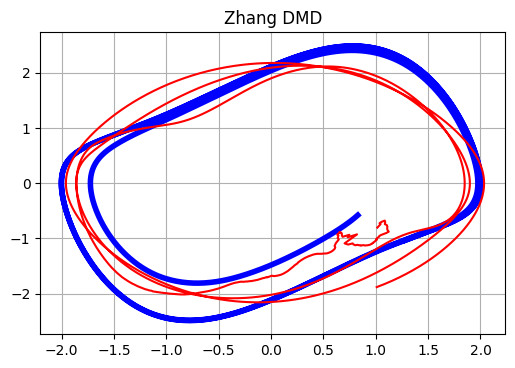

In [14]:
indices_zhang=np.array([i for i in range (Z.shape[1])]); times=[i for i in range(m+100)]
reconstructed_zhang = DMD_reconstruction(vdp[:,:kraj], Z, indices_zhang, Lambda, times)

plt.figure(dpi=100)
plt.plot(vdp[-2,:kraj], vdp[-1,:kraj], color="b", lw=4)
plt.plot(reconstructed_zhang[-2,:kraj], reconstructed_zhang[-1,:kraj], color="r")
plt.grid()
plt.title('Zhang DMD')
plt.show()

In [15]:
q=300 #moram imati vise od 240 elemenata za sad
Z_nas, Lambda_nas, r, Q, L = fGEDMDQ_multiple_trajectories(vdp[:,:q], vdp[:,1:q+1], tol=1e-6)
start_nas = time.time()
for k in range(q, kraj-1):
    Z_nas, Lambda_nas, r, Q, L = fDMD_added_snap(np.bmat([vdp[:,k],vdp[:,k+1]]).T, Q, L, tol=1e-6)
end_nas = time.time()
print("time: ", end_nas-start_nas, "sec")

print(Lambda_nas); print(Z_nas)


time:  62.158196687698364 sec
[-9.71005444e-01+0.00000000e+00j -9.63926894e-01+1.04097139e-01j
 -9.63926894e-01-1.04097139e-01j -9.48557442e-01+2.04169118e-01j
 -9.48557442e-01-2.04169118e-01j -9.21794112e-01+3.05602710e-01j
 -9.21794112e-01-3.05602710e-01j -9.23027594e-01+7.82922321e-02j
 -9.23027594e-01-7.82922321e-02j -8.99306373e-01+2.34643958e-01j
 -8.99306373e-01-2.34643958e-01j -8.81343857e-01+4.01210390e-01j
 -8.81343857e-01-4.01210390e-01j -8.37010803e-01+4.91876000e-01j
 -8.37010803e-01-4.91876000e-01j -8.55498598e-01+3.82800392e-01j
 -8.55498598e-01-3.82800392e-01j -7.79476298e-01+5.80395739e-01j
 -7.79476298e-01-5.80395739e-01j -7.86367176e-01+5.19755375e-01j
 -7.86367176e-01-5.19755375e-01j -7.07256223e-01+6.59812509e-01j
 -7.07256223e-01-6.59812509e-01j -7.07608343e-01+6.41035184e-01j
 -7.07608343e-01-6.41035184e-01j -6.41460863e-01+7.28960161e-01j
 -6.41460863e-01-7.28960161e-01j -5.59544160e-01+7.96183274e-01j
 -5.59544160e-01-7.96183274e-01j -5.99911180e-01+7.48229787e

In [ ]:
Z_nas.shape #104x106 - zasto.. 
        ##ne znam otkad je ova prije napomena, sad je 120x120 - valjda popravljeno nesto

(120, 120)

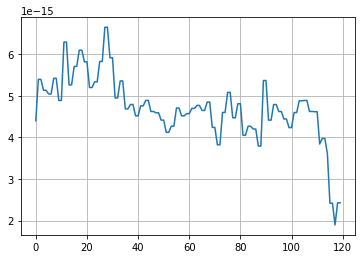

In [ ]:
plt.plot(r) #uspjesno smanjeno (bilo je veceg reda kad sam ranije racunala..)
plt.grid()

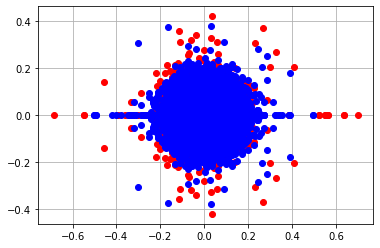

In [18]:
plt.plot(np.real(Z), np.imag(Z), 'o', color="r")
plt.plot(np.real(Z_nas), np.imag(Z_nas), 'o', color="b")
plt.grid()
plt.show()

(120,)


c:\Users\elawi\miniconda3\envs\myenv\lib\site-packages\ipykernel_launcher.py:9: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if __name__ == '__main__':


(86,)


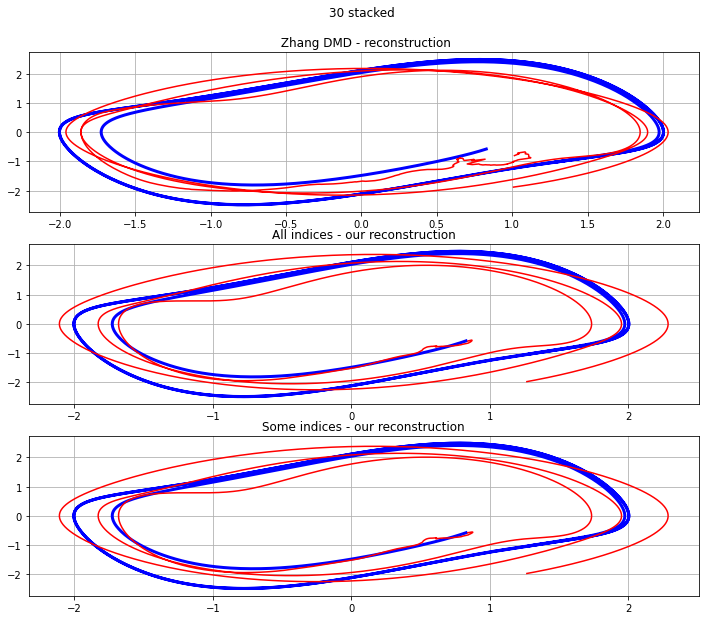

In [ ]:
indices_nas=np.array([i for i in range (Z_nas.shape[1])]); times=[i for i in range(m+100)]
#indices_nas = np.where(r<np.mean(r))[0] #ako s ovime imam 35 indeksa umjesto 59 i slicni rezultat..
print(indices_nas.shape)
reconstructed_nas = DMD_reconstruction(vdp[:,:kraj], Z_nas, indices_nas, Lambda_nas, times)

plt.figure(figsize=(12, 10))

plt.subplot(3,1,1)
plt.plot(vdp[-2,:kraj], vdp[-1,:kraj], color="blue", lw=3)
plt.plot(reconstructed_zhang[-2,:kraj], reconstructed_zhang[-1,:kraj], color="red")
plt.grid()
plt.title("30 stacked \n\n Zhang DMD - reconstruction")

plt.subplot(3,1,2)
plt.plot(vdp[-2,:kraj], vdp[-1,:kraj], color="blue", lw=3)
plt.plot(reconstructed_nas[-2,:kraj], reconstructed_nas[-1,:kraj], color="red")
plt.grid()
plt.title("All indices - our reconstruction")


indices_nas = np.where(r<5e-15)[0] #ako s ovime imam 35 indeksa umjesto 59 i slicni rezultat..
print(indices_nas.shape)
reconstructed_nas_dio = DMD_reconstruction(vdp[:,:kraj], Z_nas, indices_nas, Lambda_nas, times)

plt.subplot(3,1,3)
plt.plot(vdp[-2,:kraj], vdp[-1,:kraj], color="blue", lw=3)
plt.plot(reconstructed_nas_dio[-2,:kraj], reconstructed_nas_dio[-1,:kraj], color="red")
plt.grid()
plt.title("Some indices - our reconstruction")

plt.show()

#5e-15 ok threshold, 4e-15 premali..
